In [18]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Sklearn for preprocessing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder

# Configure visual settings
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (10, 6)

import warnings
warnings.filterwarnings('ignore')

In [19]:
# Load the datasets
train_df = pd.read_csv('train.csv')
test_df = pd.read_csv('test.csv')

print(f"Training Data Shape: {train_df.shape}")
print(f"Test Data Shape: {test_df.shape}")

Training Data Shape: (1444, 4)
Test Data Shape: (362, 3)


In [20]:
# View the first few rows
display(train_df.head())

# Check data types and missing values
print("\n--- Data Info ---")
train_df.info()

# Check for duplicates
duplicates = train_df.duplicated().sum()
print(f"\nDuplicate Rows: {duplicates}")

# Statistical Summary
print("\n--- Statistical Summary ---")
display(train_df.describe())

,sample_id,signal_strength,response_level,category
0,901,722.566585,153.933763,Group_C
1,1799,210.432525,454.613761,Group_B
2,1129,152.569777,431.993189,Group_B
3,965,670.294068,-6.559720,Group_C
4,395,49.418875,444.775273,Group_B



--- Data Info ---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1444 entries, 0 to 1443
Data columns (total 4 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   sample_id        1444 non-null   int64  
 1   signal_strength  1444 non-null   float64
 2   response_level   1444 non-null   float64
 3   category         1444 non-null   object 
dtypes: float64(2), int64(1), object(1)
memory usage: 45.3+ KB

Duplicate Rows: 0

--- Statistical Summary ---


,sample_id,signal_strength,response_level
count,1444.000000,1444.000000,1444.000000
mean,900.507618,284.409822,294.195655
std,519.917946,245.218606,170.621509
min,1.000000,-62.577392,-55.080920
25%,455.750000,62.054367,127.287543
50%,904.000000,200.055241,351.545185
75%,1347.250000,536.943071,449.192770
max,1806.000000,756.037234,543.566645


Class Proportions:
category
Group_B    49.099723
Group_C    33.310249
Group_A    17.590028
Name: proportion, dtype: float64


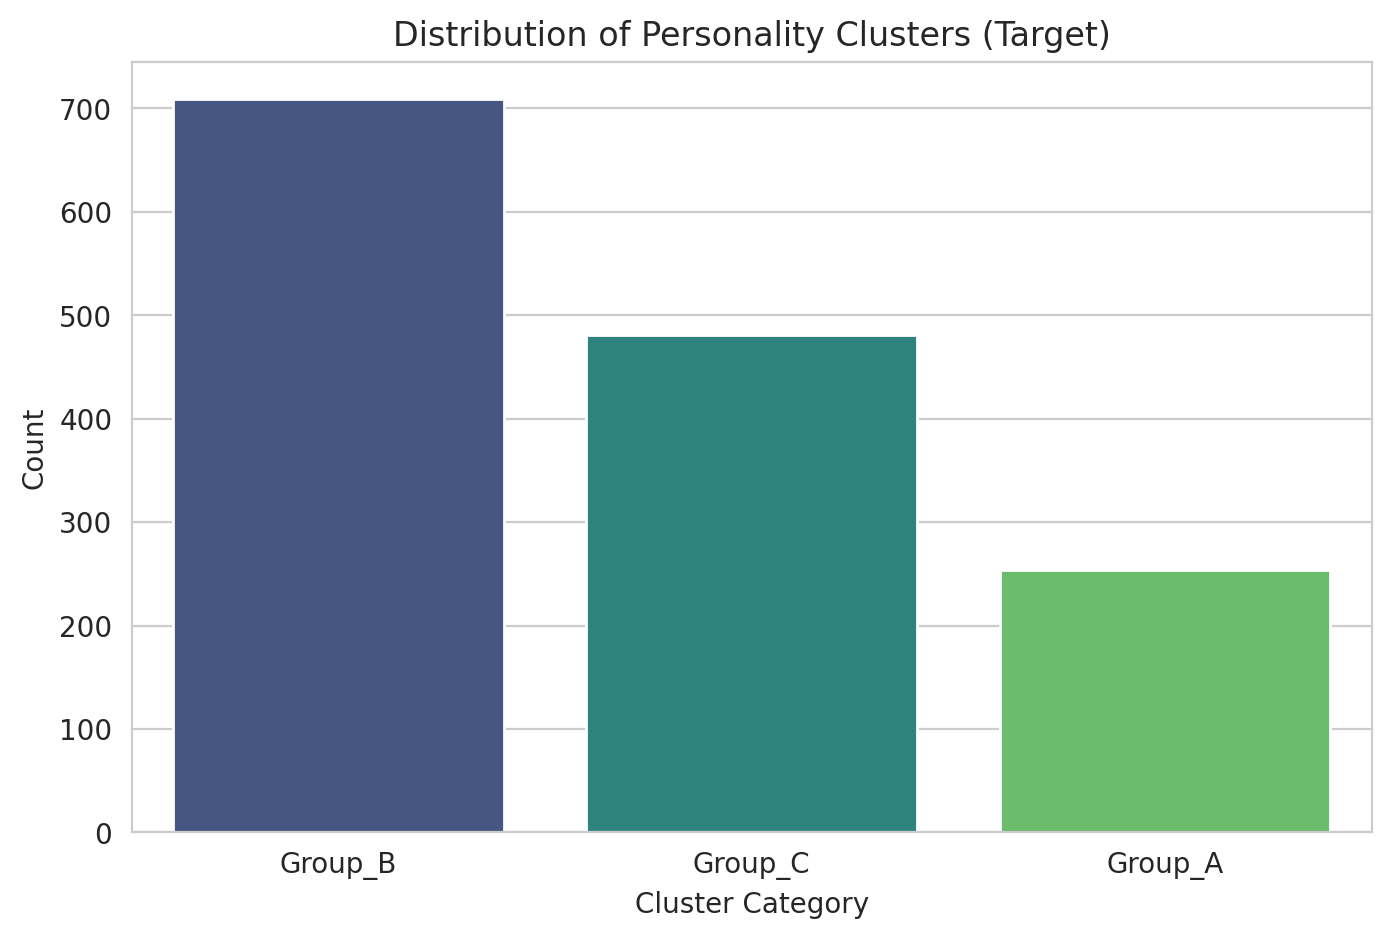

In [21]:
# Visualize the class balance
plt.figure(figsize=(8, 5))
sns.countplot(data=train_df, x='category', palette='viridis', order=train_df['category'].value_counts().index)
plt.title('Distribution of Personality Clusters (Target)')
plt.xlabel('Cluster Category')
plt.ylabel('Count')

# Calculate percentages
counts = train_df['category'].value_counts(normalize=True) * 100
print("Class Proportions:")
print(counts)
plt.show()

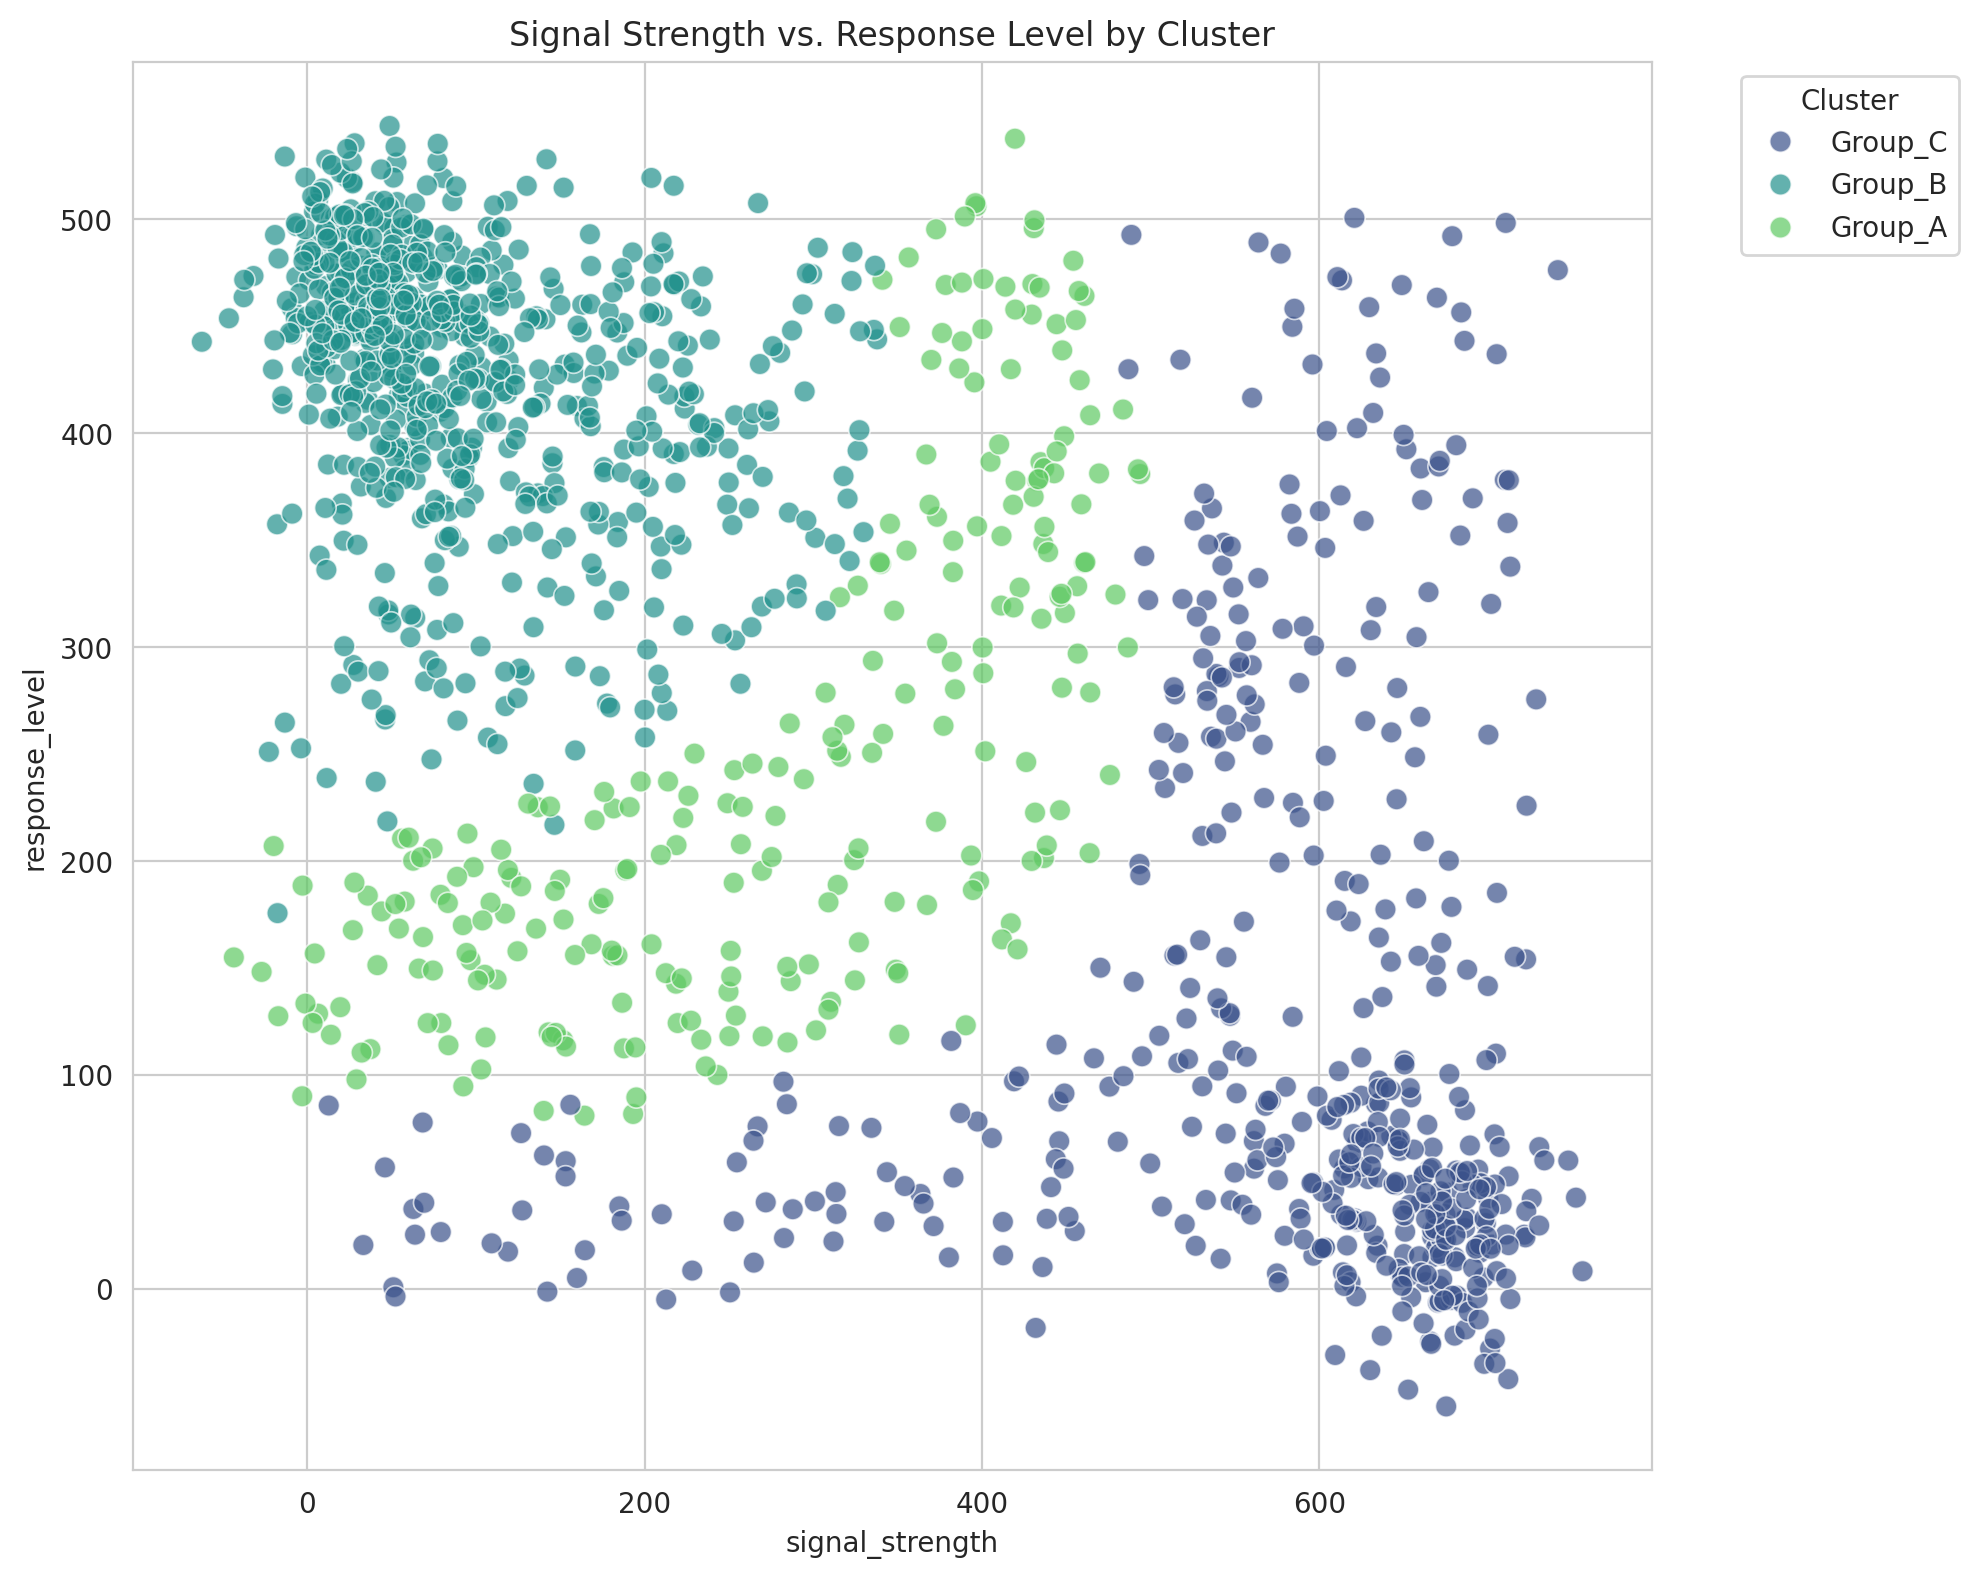

In [22]:
# Visualize the relationship between the two signals
plt.figure(figsize=(10, 8))
sns.scatterplot(
    data=train_df, 
    x='signal_strength', 
    y='response_level', 
    hue='category', 
    palette='viridis', 
    alpha=0.7, 
    s=60
)
plt.title('Signal Strength vs. Response Level by Cluster')
plt.legend(title='Cluster', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

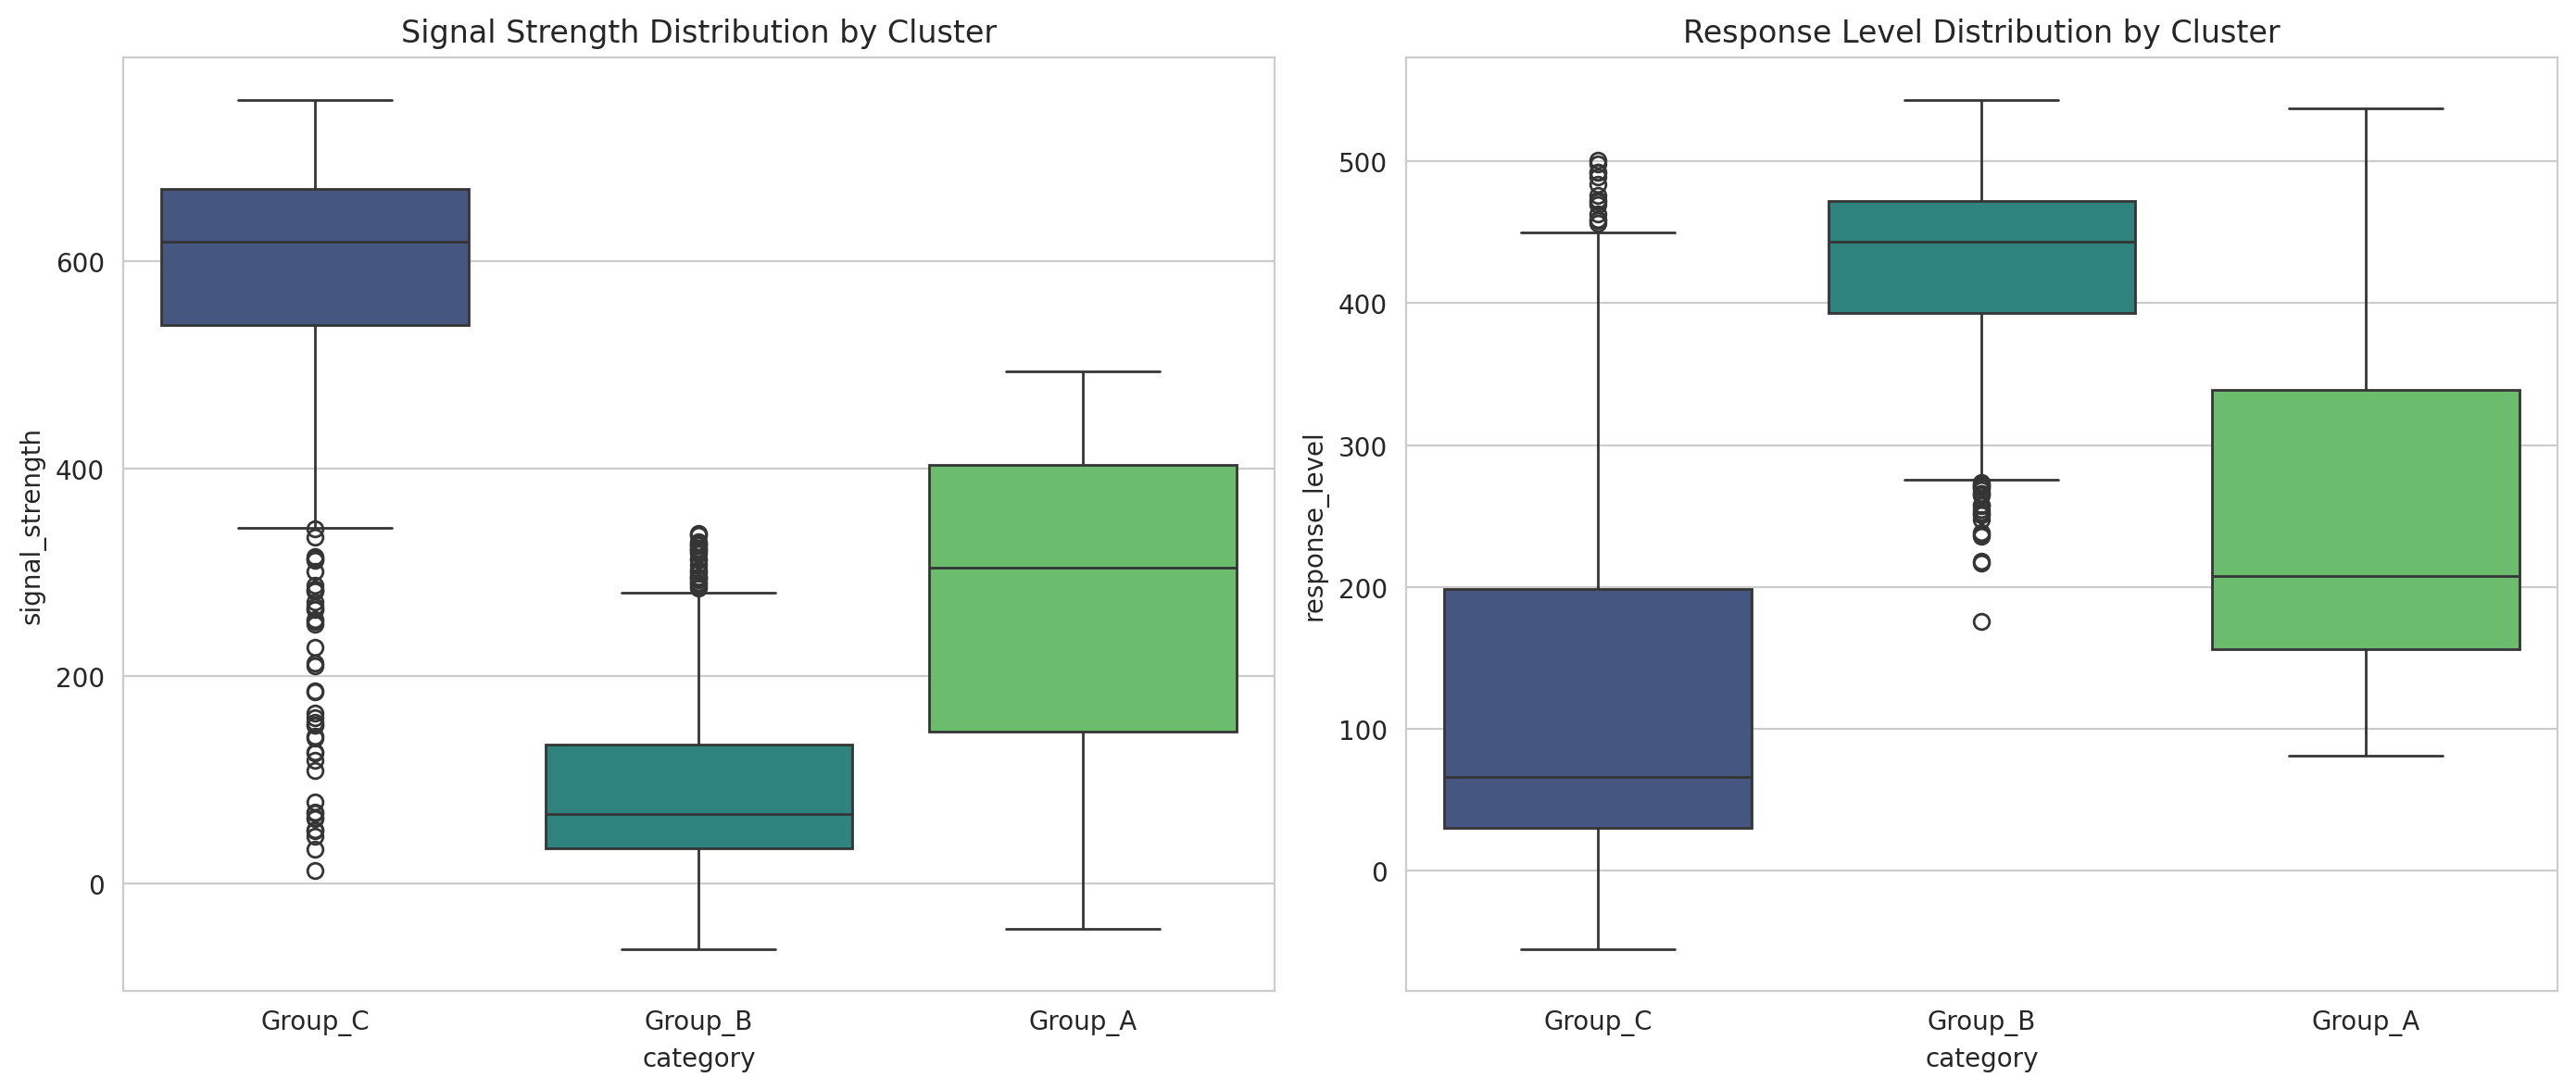

In [23]:
# Plot boxplots to see distributions and potential outliers
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

sns.boxplot(data=train_df, x='category', y='signal_strength', palette='viridis', ax=axes[0])
axes[0].set_title('Signal Strength Distribution by Cluster')

sns.boxplot(data=train_df, x='category', y='response_level', palette='viridis', ax=axes[1])
axes[1].set_title('Response Level Distribution by Cluster')

plt.tight_layout()
plt.show()

In [24]:
# 1. Separate Features and Target
X = train_df.drop(['sample_id', 'category'], axis=1)
y = train_df['category']

# 2. Encode the Target Variable
# Group_A -> 0, Group_B -> 1, Group_C -> 2
le = LabelEncoder()
y_encoded = le.fit_transform(y)

# Store the mapping for later reference
label_mapping = dict(zip(le.classes_, le.transform(le.classes_)))
print(f"Target Mapping: {label_mapping}")

# 3. Split into Train and Validation Sets (80% Train, 20% Val)
# Stratify ensures the class balance remains the same in both sets
X_train, X_val, y_train, y_val = train_test_split(
    X, y_encoded, test_size=0.2, random_state=42, stratify=y_encoded
)

print(f"Train Set Shape: {X_train.shape}")
print(f"Validation Set Shape: {X_val.shape}")

Target Mapping: {'Group_A': np.int64(0), 'Group_B': np.int64(1), 'Group_C': np.int64(2)}
Train Set Shape: (1155, 2)
Validation Set Shape: (289, 2)


In [25]:
from sklearn.preprocessing import PowerTransformer, StandardScaler
import pandas as pd
# --- Combined Transformation Cell ---

# 1. Initialize Transformers
pt = PowerTransformer()
scaler = StandardScaler()

# 2. Step A: Power Transform (Stabilize Variance)
# Fit on Train, Transform both
X_train_pt = pd.DataFrame(pt.fit_transform(X_train), columns=X_train.columns)
X_val_pt = pd.DataFrame(pt.transform(X_val), columns=X_val.columns)

# 3. Step B: Standard Scaling (Normalize to Mean=0, Std=1)
# Fit on the *Power Transformed* data
X_train_scaled = pd.DataFrame(scaler.fit_transform(X_train_pt), columns=X_train.columns)
X_val_scaled = pd.DataFrame(scaler.transform(X_val_pt), columns=X_val.columns)



print("Transformation & Scaling Complete.")
print("First 5 rows of fully processed training data:")
display(X_train_scaled.head())

Transformation & Scaling Complete.
First 5 rows of fully processed training data:


,signal_strength,response_level
0,-0.258979,-0.703241
1,-1.198387,-0.941827
2,1.265786,-1.502051
3,-0.839057,0.523143
4,1.240393,-1.194295


In [11]:
# --- Feature Engineering Cell ---
# Run this AFTER the scaling cell to add geometric features

def add_engineered_features(df):
    # Ensure we are working on a copy to avoid SettingWithCopy warnings
    df = df.copy()
    
    # 1. Interaction: Combined effect of signal and response
    df["interaction"] = df["signal_strength"] * df["response_level"]

    # 2. Magnitude: Distance from the center (0,0)
    # Since data is scaled (mean=0), this effectively measures "how extreme" the point is.
    # Group A (Central) will have low magnitude, B and C will have high magnitude.
    df["magnitude"] = np.sqrt(df["signal_strength"]**2 + df["response_level"]**2)

    # 3. Ratio: Signal relative to Response
    # Adding a tiny epsilon (1e-6) to avoid division by zero errors
    df["ratio"] = df["signal_strength"] / (df["response_level"] + 1e-6)

    return df

# Apply the feature engineering to your SCALED DataFrames
X_train_eng = add_engineered_features(X_train_scaled)
X_val_eng = add_engineered_features(X_val_scaled)

print("Feature Engineering Complete.")
print(f"New Feature Count: {X_train_eng.shape[1]}")
print("\nFirst 5 rows with added features:")
display(X_train_eng.head())

Feature Engineering Complete.
New Feature Count: 5

First 5 rows with added features:


,signal_strength,response_level,interaction,magnitude,ratio
0,-0.422669,-0.771766,0.326201,0.879927,0.547665
1,-1.102091,-0.999540,1.101584,1.487845,1.102599
2,1.353412,-1.489550,-2.015975,2.012582,-0.908605
3,-0.896976,0.502848,-0.451043,1.028310,-1.783787
4,1.318921,-1.229812,-1.622026,1.803328,-1.072458
